# Kickstartin' Success

By: Aditi Lakra, Natasha Nath, Priscilla Mannuel, Suryoday Roy

<a href="https://www.vecteezy.com/vector-art/131197-money-team"><img src="header.jpg" width="300"></a>

In this study, we will explore [data](https://webrobots.io/kickstarter-datasets/) on Kickstarter projects and build a model to predict campaign success or failure as well as explore the drivingfactors.

* [Introduction](#intro)
* [Initialization](#init)
* [Predictive Models](#model)
* [Evaluation](#eval)
* [Implementation](#imple)
* [Implications](#impli)
* [Future Work](#fw)

<h4><center>...</center></h4>

<a id='intro'><h2>Introduction</h2></a>

Nowadays if you have a great idea but not the means, crowdsourcing on Kickstarter sounds compelling. However, only 44% percent of campaigns on Kickstarter reaches their funding goal. Before you jump into Kickstarter, how do you know if it's the right platform for you? What makes a successful Kickstarter campaign? What is a realistic funding goal? By leveraging the tools and power of data analytics, we seek to answer these questions and build a model to predict the success (or failure) of a potential campaign.

<h2><a id='intro'>Initialization</a></h2>

In [55]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
import os, json
from scipy.stats import skew
from scipy.stats import ttest_ind, f_oneway, lognorm, levy, skew, chisquare
from sklearn.preprocessing import normalize, scale

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

A large dataset provided by [Web Robots](https://webrobots.io/kickstarter-datasets/) was used to train the model. The dataset contains kickstarter campaigns collected monthly through webscrapping. Each dataset is composed of all kickstarter campaigns up to a set maximum for each category. We utilized the data collected up until January 2018.

In [56]:
%%capture
# Download dataset
# Check if the dataset is present on local disk and load it
if os.path.exists('Kickstarter_2018-01.csv'):
    data = pd.read_csv('Kickstarter_2018-01.csv', error_bad_lines=False)

In [57]:
# Print the size of the dataset
print ("Number of rows:", data.shape[0])
print ("Number of columns: ", data.shape[1])

Number of rows: 194475
Number of columns:  86


<h2><a id='model'>Predictive Models</a></h2>

**Summary**

The initial dataset contained 194475 transactions with 86 time-series, categorical and numerical variables. In order to build the final model, the process is brokened down into (1) [Data cleaning](#s1), (2) [Feature engineering](#s2) (3) [Exploratory data analysis](#s3) and (4) [Building the model](#s4).

**Note:** The code to make predictions is provided in a function as success_predictor.py

<h3><a id='s1'>Data Cleaning</a></h3>

In [58]:
# define a function to clean a loaded dataset

def clean(mydata):
    
    """
    This function cleans the input dataframe mydata:
    
    input:
        mydata: pandas.dataframe
    output: 
        pandas.dataframe

    """
    
    data = mydata.copy()
    
    #get rid of uneccessary columns in training and testing
    selected_cols = ['backers_count',
                     'blurb',
                     'category.id',
                     'category.name',
                     'category.parent_id',
                     'category.slug',
                     'country',
                     'created_at',
                     'currency',  ## Added by NN
                     'deadline',
                     'goal',
                     'launched_at',
                     'name',
                     'spotlight',
                     'staff_pick',
                     'state',
                     'usd_pledged',
                     'usd_type']
    
    data = data[selected_cols]

    #drop data with empty blurb or empty name entries
    #given more time, webscrapped missing entries
    data = data.dropna() 

    #select only data with known status
    successful = data['state'] == "successful"
    failed = data['state'] == "failed"
    cancelled = data['state'] == "cancelled"
    suspended = data['state'] == "suspended"
    data = data.loc[failed | successful | cancelled | suspended]

    #label categorical collumns                   ##Commented by NN
    #categorical_cols = ['category.id',
    #                    'category.parent_id',
    #                    'country',
    #                    'spotlight',
    #                    'staff_pick',
    #                    'state',
    #                    'usd_type']
    #data[categorical_cols] = pd.Categorical

    #label numerical collumns
    num_cols = ['usd_pledged',
                'deadline',
                'created_at',
                'launched_at']
    data[num_cols] = data[num_cols].apply(pd.to_numeric, errors='coerce')

    #because there are some "bad lines" a.k.a lines that are shifted to the right due to bad parsing
    #subset rows that are correctly parsed
    data = data.dropna()

    #label datetime collumns
    data['created_at'] = pd.to_datetime(data['created_at'],unit='s')
    data['launched_at'] = pd.to_datetime(data['launched_at'],unit='s')
    data['deadline'] = pd.to_datetime(data['deadline'],unit='s')    ## Corrected the variable
    
    #CORRECT RANGE
    
    return data

**Let's clean the data... *scrub* *scrub* *scrub* **

In [59]:
print("Data dim before cleaning:", data.shape)
data = clean(data)
print("Data dim after cleaning:", data.shape)

Data dim before cleaning: (194475, 86)
Data dim after cleaning: (157082, 18)


In [60]:
data.columns[data.isnull().any()]

Index([], dtype='object')

<h3><a id='s3'>Feature Engineering</a></h3>

In order to gain a deeper understanding of Kickstarter environment and the drivers to successful campaigns, new features are intuitively engineered from current variables. The end results reduced the dataset to the following features:

* **success**: boolean feature indicating campaign (1) success (0) failure
* **name_len**: length of name of project
* **desc_len**: length of the short description or blurb
* **state**: successful, failed, cancelled, or suspended
* **duration**: days between creation and launch of campaign
* **time variables**: month, wday (day of week), hour (hour of day)
* **category**:
* **subcategory**:
* **country**:
* **spotlight**:
* **staff_picked**:
* **goal**:
* pics_count:

Additionally, these features can be included to predict campaigns that have already started:

* comments: the number of comments
* **traction**: rate of gaining backers, total number of backers divided by total number of weeks


In [61]:
def engineer_features(mydata):
    
    """
    This function generates new features for the input dataframe mydata:
    
    input:
        mydata: pandas.dataframe
    output: 
        pandas.dataframe

    """
    
    data = mydata.copy()

    # create success variable (PREDICT)
    #data['success'] = data['state'].astype('category')
    #data['success'] = pd.Categorical.from_array(data.success).codes
    
    #data = data.drop(drop_cols, axis = 1)
    data['state'].replace('suspended','failed',inplace=True)
    
    #Categories is initially a json datatype that would need to be deserialized to the Python native datatype of dictionary.
    data['catg.type'], data['catg.subtype'] = data['category.slug'].str.split('/', 1).str
    
    data['state_num'] = data['state'].apply(lambda x: 1 if x=='successful' else 0)
    
    data['launched_at_hr'] = data['launched_at'].apply(lambda x: x.hour) + 1
    data['launched_at_dow'] = data['launched_at'].apply(lambda x: x.dayofweek + 1) #Monday=1, Sunday=7
    data['launched_at_mo'] = data['launched_at'].apply(lambda x: x.month)
    data['launched_at_yr'] = data['launched_at'].apply(lambda x: x.year)
    
    data['deadline_hr'] = data['deadline'].apply(lambda x: x.hour) + 1
    data['deadline_dow'] = data['deadline'].apply(lambda x: x.dayofweek + 1) #Monday=1, Sunday=7
    data['deadline_mo'] = data['deadline'].apply(lambda x: x.month)
    data['deadline_yr'] = data['deadline'].apply(lambda x: x.year)
    
    data['created_at_hr'] = data['created_at'].apply(lambda x: x.hour) + 1
    data['created_at_dow'] = data['created_at'].apply(lambda x: x.dayofweek + 1) #Monday=1, Sunday=7
    data['created_at_mo'] = data['created_at'].apply(lambda x: x.month)
    data['created_at_yr'] = data['created_at'].apply(lambda x: x.year)
    
    #To plot the number of campaigns per month for all years
    data['count'] = 1
    
    data['success'] = (data['state'] == 'successful')
    
    #State_changed_at is column describing when the campaign changed state to either successful, failed, cancelled or suspended. 
    #Since this will not be known ahead of time for a given campaign, this is not a good datetime to use in the following 
    #look at the time differences between our dates.
    #creation and launch
    #launch and deadline
    data['launched-created'] = (data.launched_at - data.created_at).dt.components.days
    data['deadline-launched'] = (data.deadline - data.launched_at).dt.components.days
    
    
    return data

**Let's engineer new features!**

In [62]:
print("Data dim before feature engineering:", data.shape)
data = engineer_features(data)
print("Data dim after feature engineering:", data.shape)

Data dim before feature engineering: (157082, 18)
Data dim after feature engineering: (157082, 37)


In [63]:
# make spotlight into boolean
# spotlightmap = {True: True, False: False, 'True': True, 'False': False}

# data['spotlight'] = data['spotlight'].map(spotlightmap)

data['spotlight'].unique()

array([False, True, 'True', 'False'], dtype=object)

<h3><a id=''>Sanity Check</a></h3>
<br>


State_changed_at is column describing when the campaign changed state to either successful, failed, cancelled or suspended. Since this will not be known ahead of time for a given campaign, this is not a good datetime to use in the following look at the time differences between our dates.

* creation and launch
* launch and deadline

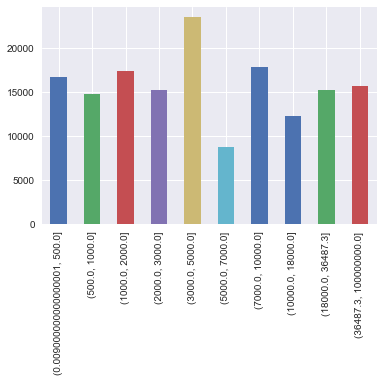

In [64]:
pd.qcut(data['goal'], 10).value_counts().sort_index().plot(kind='bar')

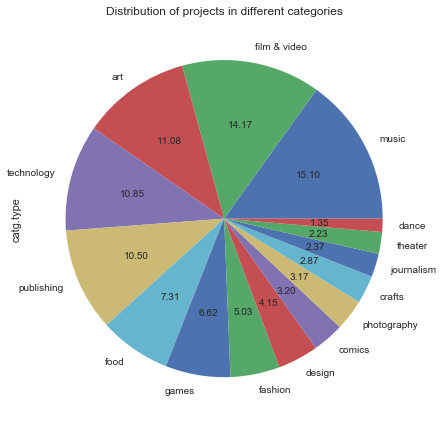

In [65]:
data['catg.type'].value_counts().plot.pie(autopct='%.2f',figsize=(6,6))
plt.title('Distribution of projects in different categories')
plt.tight_layout()

Simple quality check: Let's check to make sure no launch dates came after before deadline dates

In [66]:
np.any(data.deadline < data.launched_at)

False

In [67]:
data.launched_at_yr.value_counts()

2015    34358
2014    31423
2016    21941
2017    18126
2012    16877
2013    15280
2011    12269
2010     6114
2009      691
2018        3
Name: launched_at_yr, dtype: int64

The following plot will look at counts in campaigns from 2009 to 2018 grouped by month.

In [68]:
data['count'] = 1

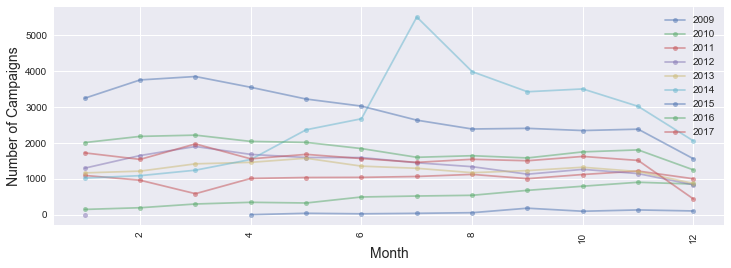

In [69]:
def plot_monthly_campaign_count(n):
    
    mth = data[data['launched_at_yr'] == n]
    mth_cnt = mth.groupby('launched_at_mo').count()['count']
    mth_cnt.plot(marker='o', markersize=5, alpha=.5, rot=90)

fig = plt.figure(figsize=(12, 4))
for i in range(2009, 2019):
    plot_monthly_campaign_count(i)
plt.ylabel('Number of Campaigns', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(range(2009, 2018))
plt.show()

Peak campaign count occured in the month of july in 2014. I wonder what caused that? Not really any seasonality is readily apparent.

In [70]:
pd.crosstab(data.launched_at_mo, data.launched_at_yr)

launched_at_yr,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
launched_at_mo,,,,,,,,,,
1,0,149,1095,1298,1166,1022,3245,2010,1723,3
2,0,196,962,1649,1215,1089,3754,2182,1542,0
3,0,300,587,1901,1418,1241,3849,2217,1973,0
4,3,347,1012,1681,1460,1540,3549,2042,1557,0
5,41,328,1037,1594,1574,2366,3222,2015,1682,0
6,27,495,1041,1593,1354,2673,3025,1843,1565,0
7,40,522,1066,1448,1294,5506,2634,1600,1459,0
8,58,542,1124,1339,1172,3985,2388,1644,1545,0
9,183,680,1005,1130,1230,3425,2406,1582,1504,0


In [71]:
data.staff_pick.value_counts()

False    130281
True      19056
False      6786
True        959
Name: staff_pick, dtype: int64

In [72]:
data.staff_pick.unique()

array(['False', 'True', False, True], dtype=object)

We observe discrepancy in values and correct it to only reflect True/False

In [73]:
data = data.replace({'staff_pick': {'True': True, 'False': False}})

In [74]:
data.staff_pick.value_counts()

False    137067
True      20015
Name: staff_pick, dtype: int64

In [75]:
staff_picked = data.staff_pick.value_counts()
print("Not so nice, ~ %g%% are staff picked" % (staff_picked[1] * 100 / staff_picked.sum()).round())

Not so nice, ~ 13% are staff picked


In [76]:
data['success'] = (data['state'] == 'successful')

In [77]:
data.success.value_counts()

True     84095
False    72987
Name: success, dtype: int64

## Plots

State_changed_at is column describing when the campaign changed state to either successful, failed, cancelled or suspended. Since this will not be known ahead of time for a given campaign, this is not a good datetime to use in the following look at the time differences between our dates.

* creation and launch
* launch and deadline

In [78]:
data['launched-created'].describe()

count    157082.000000
mean         39.321437
std         104.201581
min           0.000000
25%           2.000000
50%           9.000000
75%          32.000000
max        2313.000000
Name: launched-created, dtype: float64

In [79]:
data['deadline-launched'].describe()

count    157082.000000
mean         33.506920
std          12.711859
min           1.000000
25%          30.000000
50%          30.000000
75%          35.000000
max          91.000000
Name: deadline-launched, dtype: float64

<h3><a id='s1'>Exploratory Data Analysis</a></h3>
<br>
<center>**Unsupervised learning**</center>

In order to narrow our exploration. We studied the correlation and utilized clustering to investigate latent drivers that contribute to the success of a campaign.

<h4><center>...</center></h4>

**Target Variable: Success** <br>


Text(0.5,1,'Distribution of successful (1)/failed (0) projects')

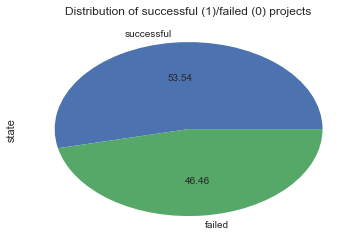

In [80]:
data['state'].value_counts().plot.pie(autopct='%.2f')
plt.title('Distribution of successful (1)/failed (0) projects')

In [81]:
stats = pd.DataFrame(data.groupby(['state']).size())
stats['Project proportion(%)'] = round((data.groupby(['state']).size()/sum(data.groupby(['state']).size()))*100,2)
stats['Project median goal($)'] = round((data.groupby(['state'])['goal'].median()),2).astype(str)
stats['Project average goal($)'] = round(data.groupby(['state'])['goal'].mean(),2)
stats['Median Pledged($)'] = round((data.groupby(['state'])['usd_pledged'].median()),2).astype(str)
stats['Average pledged($)'] = round(data.groupby(['state'])['usd_pledged'].mean(),2)
stats['Max. Backers Count'] = data.groupby(['state'])['backers_count'].max()
stats.columns.values[0]='Projects'

stats.transpose()

state,failed,successful
Projects,72987,84095
Project proportion(%),46.46,53.54
Project median goal($),7000.0,3500.0
Project average goal($),89450.5,9564.29
Median Pledged($),60.0,4618.0
Average pledged($),1172.67,18460.2
Max. Backers Count,4435,105857


**Correlation matrix** <br>

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nullam ultrices nisl odio, non fringilla lorem lacinia et. Cras in nibh diam. Donec bibendum eros nulla, et aliquam nunc ultricies in. Nulla ut lacinia justo. Donec sit amet efficitur nisl, sed porta odio. Donec et blandit augue.

In [82]:
import numpy as np;
import seaborn as sns; sns.set()

def corrmatrix(mydata,annot=True):
        
    """
    This function cleans the input dataframe mydata:
    
    input:
        mydata: pandas.dataframe
    output: 
        pandas.dataframe

    """
    
    data = mydata.copy()
    
    data_continuos = data.select_dtypes(include=['int64','float64'])
    
    continuous_variables = list(data_continuos)
    
    corr = data_continuos.corr()
    
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    
    with sns.axes_style("white"):
        ax = sns.heatmap(corr, mask=mask, annot=annot, linewidths=.5)

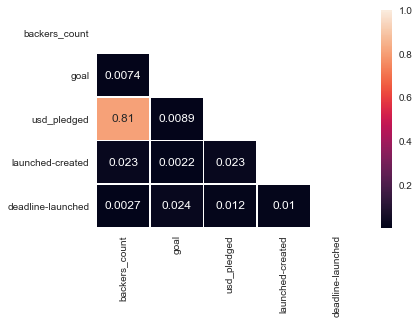

In [83]:
dropped_cols = ['category.id',
                'category.parent_id',
                'state_num',
                'launched_at_hr',
                'launched_at_dow',
                'launched_at_mo',
                'launched_at_yr',
                'deadline_hr',
                'deadline_dow',
                'deadline_mo',
                'deadline_yr',
                'created_at_hr',
                'created_at_dow',
                'created_at_mo',
                'created_at_yr',
                'count']

corrmatrix(data.drop(dropped_cols, axis=1))

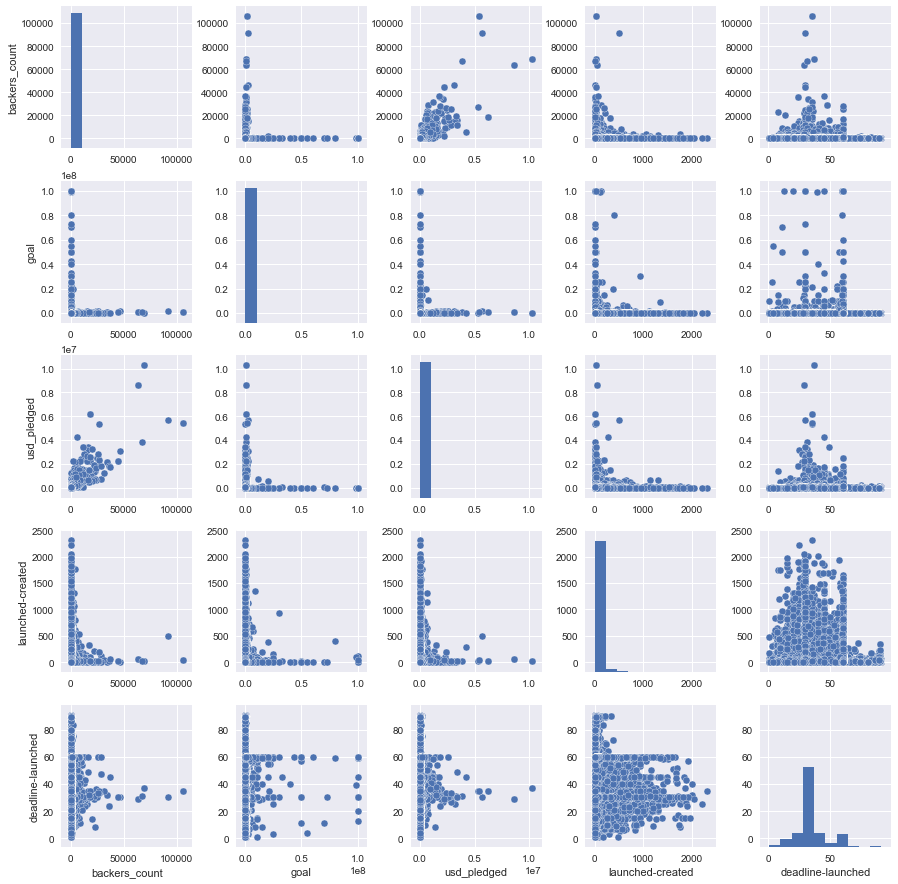

In [84]:
sns.pairplot(data.drop(dropped_cols, axis=1).select_dtypes(include=['int64','float64']), palette="husl")

**K-Means clustering** <br>
<br>
K-means clustering is one of the most widely used unsupervised machine learning algorithms that forms clusters of data based on the similarity between data instances. For this particular algorithm to work, the number of clusters has to be defined beforehand. The K in the K-means refers to the number of clusters.

1. Import kmeans and PCA through the sklearn library
2. Devise an elbow curve to select the optimal number of clusters (k)
3. Generate and visualise a k-means clusters

We need to determine optimal k.The technique to determine K, the number of clusters, is called the elbow method.

We plot values for K on the horizontal axis and the distortion on the Y axis (the values calculated with the cost function).

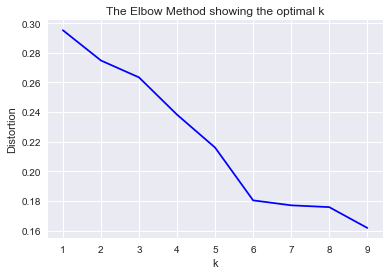

In [85]:
import matplotlib.pyplot as plt

datac=data.copy()
selected_cols=['backers_count','goal','usd_pledged']
datac=datac[selected_cols]


# scaling the data 

from sklearn.preprocessing import scale
datac = pd.DataFrame(scale(datac), columns=['backers_count','goal','usd_pledged'])

# k means clustering
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

# first step is to determine k
distortions = []
score=[]
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(datac)
    kmeanModel.fit(datac)
    distortions.append(sum(np.min(cdist(datac, kmeanModel.cluster_centers_,
                                        'euclidean'),axis=1)) / datac.shape[0])
    score.append(kmeanModel.fit(datac).score(datac) )


#Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [86]:
# plot centroids and clusters
from sklearn import cluster
centroids,labels,inertia = cluster.k_means(datac,n_clusters=5)
#Let's check the parameter cluster centers of the estimator

centroids = pd.DataFrame(centroids,
                         columns=['backers_count','goal','usd_pledged'])

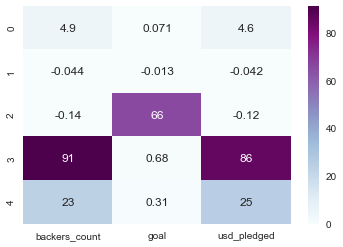

In [87]:
sns.heatmap(centroids, cmap='BuPu', annot=True)

<center>**Understading the marketplace**</center>

Throughout exploratory analysis, key understandings of Kickstarter marketplace is built.

<h4><center>...</center></h4>

**Kickstarter is predominantly domestic** <br>


Although the platform boast its global reach, 79.7% of Kickstarter's campaign creators are United States-based.

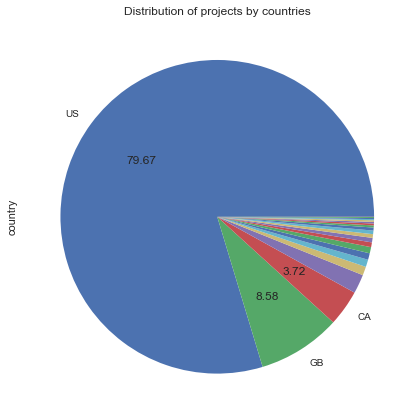

In [88]:
def my_autopct(pct):
    return ('%.2f' % pct) if pct > 2 else ''

labels = ['US', 'GB', 'CA'] + ["" for x in range(19)]

data['country'].value_counts().plot.pie(autopct=my_autopct,labels=labels,figsize=(6,6))
plt.title('Distribution of projects by countries')
plt.tight_layout()

**Kickstarter is home to the artsy-fartsy and the tech-enthusiast**<br>

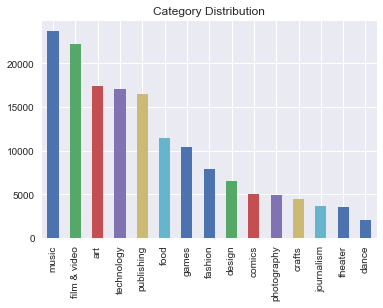

In [89]:
data['catg.type'].value_counts().plot(kind = 'bar', title = 'Category Distribution')

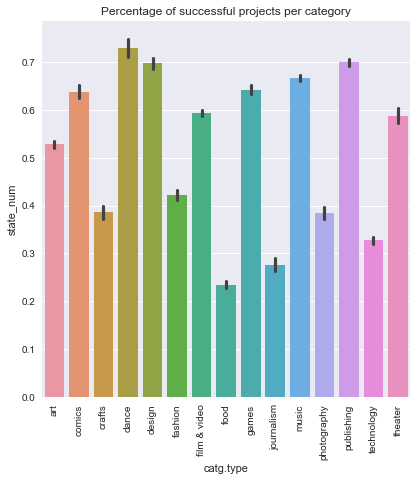

In [90]:
sns.factorplot(x='catg.type', y='state_num', kind='bar', data=data, size=6)
locs, labels = plt.xticks();
plt.title('Percentage of successful projects per category')
plt.setp(labels, rotation=90);

**Creation of campaigns varies by time** <br>
<br>
The timeline of a Kickstarter campaign includes creation of the campaign where creators set up the funding page and marketing material, launching the campaign where creators publish the campaign for others to start backing. Creation and launching is more popular during the weekday (Monday - Friday) between 4 PM - 4 AM. The timing of campaign creation and launch all coincide with the average work-hours, suggesting that people create Kickstarter campaigns during the
workday.

In [91]:
def plot_monthly_campaign_count(n):
    mth = data[data['launched_at_yr'] == n]
    mth_cnt = mth.groupby('launched_at_mo').count()['count']
    mth_cnt.plot(marker='o', markersize=5, alpha=.5, rot=90)

# Project creation density by dow and hr
c_dow_vs_hr = pd.core.frame.DataFrame({'count' : data.groupby(['created_at_dow','created_at_hr']).size()}).reset_index()
c_dow_vs_hr['created_at_dow'] = c_dow_vs_hr['created_at_dow'].astype('category')
c_dow_vs_hr = c_dow_vs_hr.pivot("created_at_dow", "created_at_hr", "count")

# Project launched density by dow and hr
l_dow_vs_hr = pd.core.frame.DataFrame({'count' : data.groupby(['launched_at_dow','launched_at_hr']).size()}).reset_index()
l_dow_vs_hr['launched_at_dow'] = l_dow_vs_hr['launched_at_dow'].astype('category')
l_dow_vs_hr = l_dow_vs_hr.pivot("launched_at_dow", "launched_at_hr", "count")

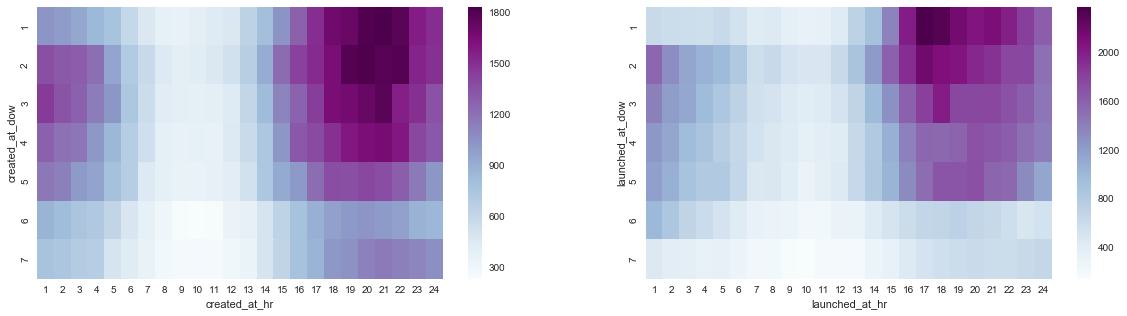

In [92]:
#plot heatmap
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
fig.subplots_adjust(hspace=0, wspace = 0.2)

sns.heatmap(c_dow_vs_hr, ax=axes[0], cmap='BuPu')
sns.heatmap(l_dow_vs_hr, ax=axes[1], cmap='BuPu')

Text(0.5,1,'Deadline weekday Distribution')

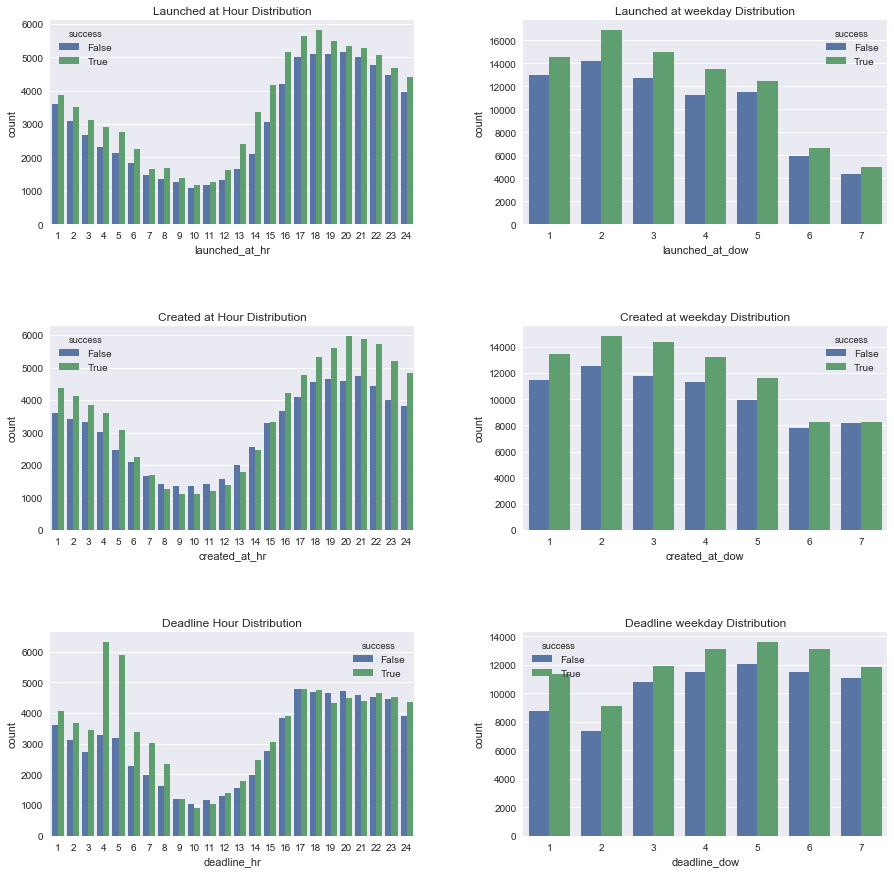

In [93]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,15))
fig.subplots_adjust(hspace=0.5, wspace = 0.3)

sns.countplot(x="launched_at_hr", hue="success", data=data, ax=axes[0, 0]).set_title('Launched at Hour Distribution')
sns.countplot(x="created_at_hr", hue="success", data=data, ax=axes[1, 0]).set_title('Created at Hour Distribution')
sns.countplot(x="deadline_hr", hue="success", data=data, ax=axes[2, 0]).set_title('Deadline Hour Distribution')
sns.countplot(x="launched_at_dow", hue="success", data=data, ax=axes[0, 1]).set_title('Launched at weekday Distribution')
sns.countplot(x="created_at_dow", hue="success", data=data, ax=axes[1, 1]).set_title('Created at weekday Distribution')
sns.countplot(x="deadline_dow", hue="success", data=data, ax=axes[2, 1]).set_title('Deadline weekday Distribution')

<center>Finding insights that matter</center>
    
After a establishing understanding of the Kickstarter nature of campaign creators, drivers that promotes success are  determined. Potential features are studied and a t-test is performed to determine whether the feature can be used to significantly distinguish successful campaigns from failed ones.

<h4><center>...</center></h4>

**Setting the right goal is as important as you'd think** <br>
The median goal for a successful campaign from the dataset is USD 5,000 while the medial goal for failed campaigns is nearly USD 17,000. We also found that 38% of failed campaigns had a goal of over USD 50,000. From the comparison below, per main category, there is a clear separation of range of goals ($) between successful and failed cases. The successful cases have way lower/achievable goal compared to the failed cases.

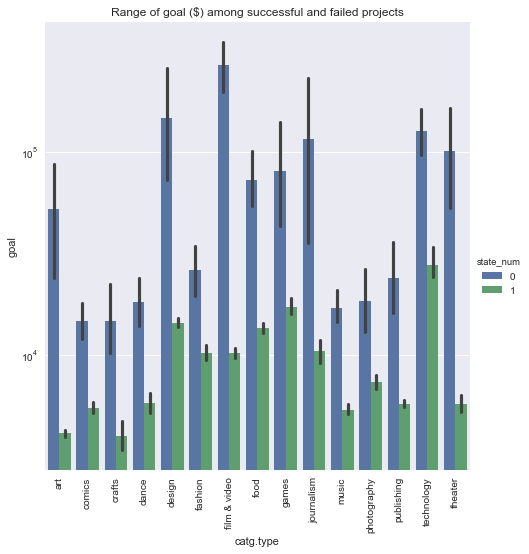

In [94]:
sns.factorplot(x='catg.type', y='goal', hue='state_num', kind='bar', data=data, size=7)
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
plt.title('Range of goal ($) among successful and failed projects')
plt.gca().set_yscale("log", nonposy='clip');

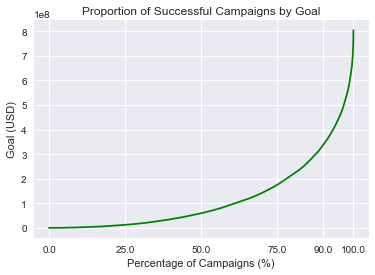

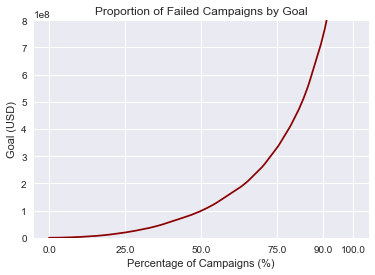

In [95]:
fig, ax = plt.subplots()

df_success = data[(data['state_num'] == 1)]

df_success = np.sort(df_success.goal).cumsum()

# Percentile values
p = np.array([0.0, 25.0, 50.0, 75.0, 90.0, 100.0])

perc_success = mlab.prctile(df_success, p=p)

plt.plot(df_success, color='green')
plt.title("Proportion of Successful Campaigns by Goal")
plt.ylabel('Goal (USD)')
plt.xlabel('Percentage of Campaigns (%)')

# Set tick locations and labels
plt.xticks((len(df_success)-1) * p/100., map(str, p))
plt.show()

fig, ax = plt.subplots()

df_fail = data[(data['state_num'] == 0)]

df_fail = np.sort(df_fail.goal).cumsum()

# Percentile values
p = np.array([0.0, 25.0, 50.0, 75.0, 90.0, 100.0])

perc_fail = mlab.prctile(df_fail, p=p)

plt.plot(df_fail, color='darkred')
plt.title("Proportion of Failed Campaigns by Goal")
plt.ylabel('Goal (USD)')
plt.xlabel('Percentage of Campaigns (%)')
plt.gca().set_ylim(0,8e8)

# Set tick locations and labels
plt.xticks((len(df_fail)-1) * p/100., map(str, p))
plt.show()

**Staff picks have significant impact on success**<br>
<br>
Kickstarter’s “staff picks” are given high-value front page real estate as “ Projects We Love” . Since these projects are given such high visibility, it’s no surprise that staff pick projects are 9.6 times more likely to be successful than those that aren’t. While it’s understandable that not all projects can be staff picks, we will touch on how Kickstarter can leverage the power of staff picks to improve its platform’s success rate in the implications section.

Staff picks are another variable of interest we are interested in determining. I can perform the same sort of analysis I will make in this notebook to staff picks. We would be interested in finding which features are associated with higher probabilities of Kickstarter staff choosing a campaign to tag with the staff pick criteria. This seems to boost backer confidence and is associated with a higher probability of success.

Text(0.5,1,'Spotlight Distribution')

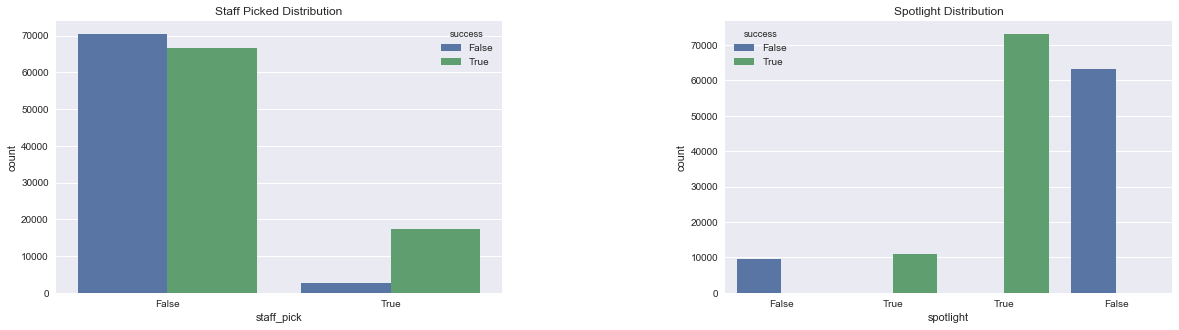

In [96]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
fig.subplots_adjust(hspace=0, wspace = 0.5)

sns.countplot(x="staff_pick", hue="success", ax=axes[0], data=data).set_title('Staff Picked Distribution')
sns.countplot(x="spotlight", hue="success", ax=axes[1], data=data).set_title('Spotlight Distribution')

In [97]:
staff_picked = data.staff_pick.value_counts()

print("Not so nice, ~ %g%% are staff picked" % (staff_picked[1] * 100 / staff_picked.sum()).round())

pd.crosstab(data.staff_pick, data.success)

Not so nice, ~ 13% are staff picked


success,False,True
staff_pick,,
False,70442,66625
True,2545,17470


**Successful campaigns invest more time in creating the campaign.** <br>
<br>
The median number of days spent between creation and launch for successful campaigns is 19, as compared to the median of 12 days spent for failed  campaigns. Furthermore, taking longer than 1 week to create your campaign makes your campaign 1.83 times more likely to succeed.

(-1, 90)

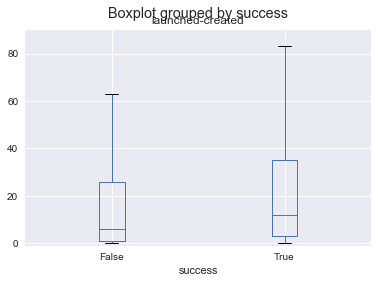

In [98]:
data.boxplot('launched-created', by='success')
plt.ylim(-1,90)

tripdist_quant <- quantile(df$Trip_distance, seq(0,1,0.01))
tripdist_quant <- data.frame(fval=seq(0,1,0.01), q=tripdist_quant, row.names=NULL)

xyplot(q ~ fval, 
       tripdist_quant,
       xlab = "Proportion", 
       ylab = "Trip Distance (miles)",
       type = c("p", "g"), 
       subset = q < 40)

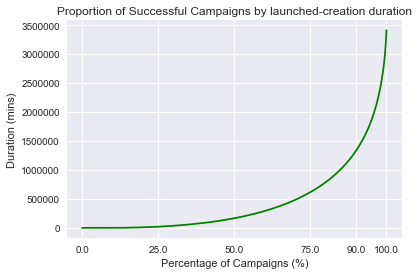

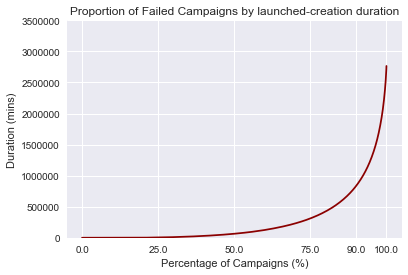

In [99]:
fig, ax = plt.subplots()

df_success = data[(data['state_num'] == 1)]

d = np.sort(df_success['launched-created']).cumsum()

# Percentile values
p = np.array([0.0, 25.0, 50.0, 75.0, 90.0, 100.0])

perc = mlab.prctile(d, p=p)

plt.plot(d, color='green')
plt.title("Proportion of Successful Campaigns by launched-creation duration")
plt.ylabel('Duration (mins)')
plt.xlabel('Percentage of Campaigns (%)')

# Set tick locations and labels
plt.xticks((len(d)-1) * p/100., map(str, p))
plt.show()

fig, ax = plt.subplots()

df_fail = data[(data['state_num'] == 0)]

d = np.sort(df_fail['launched-created']).cumsum()

# Percentile values
p = np.array([0.0, 25.0, 50.0, 75.0, 90.0, 100.0])

perc = mlab.prctile(d, p=p)

plt.plot(d, color='darkred')
plt.title("Proportion of Failed Campaigns by launched-creation duration")
plt.ylabel('Duration (mins)')
plt.xlabel('Percentage of Campaigns (%)')
plt.gca().set_ylim(0,3500000)

# Set tick locations and labels
plt.xticks((len(d)-1) * p/100., map(str, p))
plt.show()

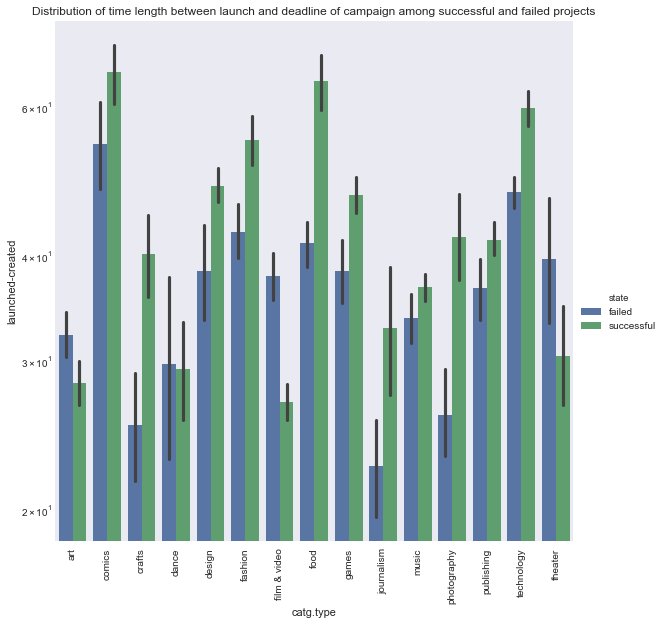

In [100]:
sns.factorplot(x='catg.type', y='launched-created', hue='state', kind='bar', data=data, size=8)
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
plt.title('Distribution of time length between launch and deadline of campaign among successful and failed projects')
plt.gca().set_yscale("log", nonposy='clip');

<h3><a id='s4'>Building the Models</a></h3>

In the search for the best model, four algorithms were investigated:

* [Random Forest](#rf)
* [Adaptive Boosting](#ada)
* [Gradient Boosting](#xg)
* [Logistic Regression](#lg)

These classification models were chosen due to their predictive power in binary classification problems. Adaptive and Gradient Boosting are both boosting methods which choose to train one strong learner (the overfitting decision tree) on multiple weak learners (underfitting learners) in sequence.

To avoid overfitting due to our limited dataset, functions for cross-validation and parameter optimization were defined such that they are applicable on either classification or regression algorithm

<h4><center>...</center></h4>

**K Fold Cross Validation:**

This function (**modelfit**) train the model given as 'alg' by performing cross-validation. It works on both regression and classification

* **alg**: sklearn model
* **dtrain**: pandas.DataFrame, training set
* **predictors**: list, labels of features (column names) to be used in the model training
* **target**: str, target variable
* **scoring_method**: str, method to be used by the cross-validation to valuate the model
* **performCV**: bool, perform Cv or not
* **printFeatureImportance**: bool, plot histogram of features importance or not
* **cv_folds**: int, degree of cross-validation

In [101]:
%%capture
# import scikit learn libraries
from sklearn import cross_validation, metrics   #model optimization and valuation tools
from sklearn.grid_search import GridSearchCV   #Perforing grid search

# define a function that help to train models and perform cv
def modelfit(alg,dtrain,predictors,target,scoring_method,performCV=True,printFeatureImportance=True,cv_folds=5):

    # train the algorithm on data
    alg.fit(dtrain[predictors],dtrain[target])
    
    #predict on train set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    if scoring_method == 'roc_auc':
        dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #perform cross-validation
    if performCV:
        cv_score = cross_validation.cross_val_score(alg,dtrain[predictors],dtrain[target],cv=cv_folds,scoring=scoring_method)
        
        #print model report
        print ("\nModel report:")
        if scoring_method == 'roc_auc':
            print ("Accuracy: %.4f" % metrics.accuracy_score(dtrain[target].values,dtrain_predictions))
            print ("Precision: %.4f" % metrics.precision_score(dtrain[target].values,dtrain_predictions))
            print ("Recall: %.4f" % metrics.recall_score(dtrain[target].values,dtrain_predictions))
            print ("AUC Score (Train): %.4f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
        if (scoring_method == 'mean_squared_error'):
            print ("Accuracy: %.4f" % metrics.mean_squared_error(dtrain[target].values,dtrain_predictions))
    if performCV:
        print ("CV Score: Mean : %.5g | Std : %.5g | Min : %.5g | Max : %.5g \n" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #print feature importance
    if printFeatureImportance:
        if dir(alg)[0] == '_Booster': #runs only if alg is xgboost
            feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
        else:
            feat_imp = pd.Series(alg.feature_importances_,predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar',title='Feature Importances')
        plt.ylabel('Feature Importe Score')
        plt.show()

**Optimize Number of Desicion Trees:**

This function, (**optimize_num_trees**), is used to tune paremeters of a predictive algorithm

* **alg**: sklearn model
* **param_test**: dict, parameters to be tuned
* **scoring_method**: str, method to be used by the cross-validation to valuate the model
* **train**: pandas.DataFrame, training data
* **predictors**: list, labels to be used in the model training process. They should be in the column names of dtrain
* **target**: str, target variable

In [102]:
# optimize n_estimator through grid search
def optimize_num_trees(alg,param_test,scoring_method,train,predictors,target):
    gsearch = GridSearchCV(estimator=alg, param_grid = param_test, scoring=scoring_method,n_jobs=2,iid=False,cv=5)
    gsearch.fit(train[predictors],train[target])
    
    return gsearch

# plot optimization results
def plot_opt_results(alg):
    cv_results = []
    for i in range(len(param_test['n_estimators'])):
        cv_results.append((alg.grid_scores_[i][1],alg.grid_scores_[i][0]['n_estimators']))
    cv_results = pd.DataFrame(cv_results)
    plt.plot(cv_results[1],cv_results[0])
    plt.xlabel('# trees')
    plt.ylabel('score')
    plt.title('optimization report')

**Splitting The Data: Train and Test**

In [103]:
data.shape

(157082, 37)

In [104]:
train = data.copy() # make a copy of the training set
# since the dataset is too big for my system, select a small sample size to carry on training and 5 folds cross validation
train = train.loc[np.random.choice(train.index,size=57082,replace=False)]
target = 'success' # set target variable - it will be used later in optimization

# test
indices = data.index[~data.index.isin(train.index)]
test = data.loc[np.random.choice(indices,size=100000,replace=False)]

**Choosing the predictors**

In [105]:
# for predictors start with candidates identified during the EDA
#univariate t-test
# drop all unecessary columns
# usd pledged and backer counts deleted if we want to predict based on project criteria???

predictors = ['category.parent_id',
              'category.id',
              'goal',
              'staff_pick',
              'launched_at_hr',
              'launched_at_dow',
              'deadline_hr',
              'deadline_dow',
              'launched-created',
              'deadline-launched']

<h2><a id='rf'>Random Forest</a></h2>

* Optimized number of trees: TBD
* Optimized predictors (in order of importance):     
    1. Category.id
    2. Goal
* ROC-AUC of test: TBD

**Firstly, let's optimize and train the model**

Optimizing the classifier...

Search grid results:
params (best): 130
score (best): 0.8319

Model report:
Accuracy: 0.7463
Precision: 0.7710
Recall: 0.7455
AUC Score (Train): 0.8341
CV Score: Mean : 0.83188 | Std : 0.0037225 | Min : 0.82594 | Max : 0.83689 



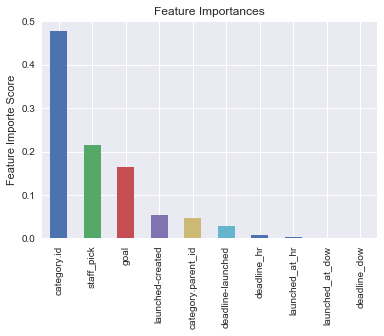


 Processing time: 0:00:51.648954


In [106]:
from sklearn.ensemble import RandomForestClassifier
print ("Optimizing the classifier...")

tic = dt.datetime.now() # initiate the timing

# optimize n_estimator through grid search
param_test = {'n_estimators': list(range(30,151,20))} # define range over which number of trees is to be optimized

# initiate classification model
model_cls = RandomForestClassifier(
    min_samples_split=2,# use default
    max_depth=5,
    max_features='auto',
    random_state = 10)

# get results of the search grid
RF_mod = optimize_num_trees(model_cls,param_test,'roc_auc',train,predictors,target)
print("\nSearch grid results:")
print("params (best):", RF_mod.best_params_['n_estimators']) 
print("score (best): %.4f" % RF_mod.best_score_)

# cross validate the best model with optimized number of estimators
modelfit(RF_mod.best_estimator_,train,predictors,target,'roc_auc')
     
print ("\n Processing time:", dt.datetime.now()-tic)

**Let’s test it by doing prediction on a test dataset**

In [107]:
RFpred = RF_mod.best_estimator_.predict(test[predictors])

print("ROC AUC: %.4f " % metrics.roc_auc_score(RFpred,test.success))

ROC AUC: 0.7445 


<h2><a id='xg'>Gradient Boosting</a></h2>

* Optimized number of trees: TBD
* Optimized predictors (in order of importance):     
    1. Category.id
    2. Goal
* ROC-AUC of test: TBD

**Firstly, let's optimize and train the model**

Optimizing the classifier...

Search grid results:
params (best): 150
score (best): 0.8811

Model report:
Accuracy: 0.8089
Precision: 0.8305
Recall: 0.8060
AUC Score (Train): 0.8980
CV Score: Mean : 0.8811 | Std : 0.0019553 | Min : 0.87756 | Max : 0.88323 



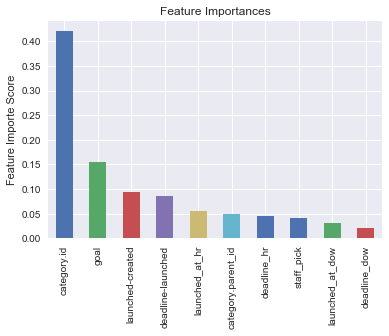


 Processing time: 0:02:35.119592


In [108]:
from sklearn.ensemble import GradientBoostingClassifier
print ("Optimizing the classifier...")

tic = dt.datetime.now() # initiate the timing

# optimize n_estimator through grid search
param_test = {'n_estimators': list(range(30,151,20))} # define range over which number of trees is to be optimized

# initiate classification model
model_cls = GradientBoostingClassifier(
    learning_rate=0.1, # use default
    min_samples_split=2,# use default
    max_depth=5,
    max_features='auto',
    subsample=0.8, # try <1 to decrease variance and increase bias
    random_state = 10)

# get results of the search grid
GB_mod = optimize_num_trees(model_cls,param_test,'roc_auc',train,predictors,target)
print("\nSearch grid results:")
print("params (best):", GB_mod.best_params_['n_estimators']) 
print("score (best): %.4f" % GB_mod.best_score_)

# cross validate the best model with optimized number of estimators
modelfit(GB_mod.best_estimator_,train,predictors,target,'roc_auc')
     
print ("\n Processing time:", dt.datetime.now()-tic)

**Let’s test it by doing prediction on a test dataset**

In [109]:
GBpred = GB_mod.best_estimator_.predict(test[predictors])

print("ROC AUC: %.4f " % metrics.roc_auc_score(XGpred,test.success))

NameError: name 'XGpred' is not defined

<h2><a id='ada'>Adaptive Boosting</a></h2>

* Optimized number of trees: TBD
* Optimized predictors (in order of importance):     
    1. Category.id
    2. Goal
* ROC-AUC of test: TBD

**Firstly, let's optimize and train the model**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
print ("Optimizing the classifier...")

tic = dt.datetime.now() # initiate the timing

# optimize n_estimator through grid search
param_test = {'n_estimators': list(range(30,151,20))} # define range over which number of trees is to be optimized

# initiate classification model
model_cls = AdaBoostClassifier(
    learning_rate=0.1, # use default
    random_state = 10)

# get results of the search grid
ADA_mod = optimize_num_trees(model_cls,param_test,'roc_auc',train,predictors,target)
print("\nSearch grid results:")
print("params (best):", ADA_mod.best_params_['n_estimators']) 
print("score (best): %.4f" % ADA_mod.best_score_)

# cross validate the best model with optimized number of estimators
modelfit(ADA_mod.best_estimator_,train,predictors,target,'roc_auc')
     
print ("\n Processing time:", dt.datetime.now()-tic)

**Let’s test it by doing prediction on a test dataset**

In [ ]:
ADApred = ADA_mod.best_estimator_.predict(test[predictors])

print("ROC AUC: %.4f " % metrics.roc_auc_score(ADApred,test.success))

<h3><a id='lg'>Logistic Regression</a></h3>

* Optimized predictors (in order of importance):     
    1. Category.id
    2. Goal
* ROC-AUC of test: TBD

**Firstly, let's optimize and train the model**

In [ ]:
from sklearn.linear_model import LogisticRegression
print ("Optimizing the classifier...")

tic = dt.datetime.now() # initiate the timing
# for predictors start with candidates identified during the EDA
#predictors = ['category.id',
#              'goal']

# optimize n_estimator through grid search
param_test = {'n_estimators': list(range(30,151,20))} # define range over which number of trees is to be optimized

# initiate classification model
LR_mod = LogisticRegression()

# cross validate the best model with optimized number of estimators
modelfit(LR_mod,train,predictors,target,'roc_auc',printFeatureImportance=False)
     
print ("\n Processing time:", dt.datetime.now()-tic)

**Let’s test it by doing prediction on a test dataset**

In [ ]:
LOGREGpred = LR_mod.predict(test[predictors])

print("ROC AUC: %.4f " % metrics.roc_auc_score(ADApred,test.success))

<h2><a id=''>XGBoost by Category.parent_id</a></h2>

* Optimized number of trees: TBD
* Optimized predictors (in order of importance):     
    1. Category.id
    2. Goal
* ROC-AUC of test: TBD

**Firstly, let's optimize and train the model**

In [ ]:
values = data['catg.type'].unique()
keys = data['category.parent_id'].unique()

dictionary = dict(zip(keys, values))
print(dictionary)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

def fit_gb_per_category(mytrain,category):
    
    train = mytrain.loc[mytrain['category.parent_id'] == category]

    print ("Optimizing the classifier...")

    tic = dt.datetime.now() # initiate the timing

    # optimize n_estimator through grid search
    param_test = {'n_estimators': list(range(30,151,20))} # define range over which number of trees is to be optimized

    # initiate classification model
    model_cls = GradientBoostingClassifier(
        learning_rate=0.1, # use default
        min_samples_split=2,# use default
        max_depth=5,
        max_features='auto',
        subsample=0.8, # try <1 to decrease variance and increase bias
        random_state = 10)

    # get results of the search grid
    GB_mod = optimize_num_trees(model_cls,param_test,'roc_auc',train,predictors,target)
    print("\nSearch grid results:")
    print("params (best):", GB_mod.best_params_['n_estimators']) 
    print("score (best): %.4f" % GB_mod.best_score_)
    
    values = data['catg.type'].unique()
    keys = data['category.parent_id'].unique()

    dictionary = dict(zip(keys, values))
    
    print("\nCategory:" + dictionary[category] + "\n")

    # cross validate the best model with optimized number of estimators
    modelfit(GB_mod.best_estimator_,train,predictors,target,'roc_auc',printFeatureImportance=False)

    print ("\n Processing time:", dt.datetime.now()-tic)
    
    print ("\nTesting the classifier...\n")
    
    pred = GB_mod.best_estimator_.predict(test[predictors])
    
    print ("TEST Accuracy: %.4f" % metrics.accuracy_score(pred,test.success))
    print ("TEST Precision: %.4f" % metrics.precision_score(pred,test.success))
    print ("TEST Recall: %.4f" % metrics.recall_score(pred,test.success))
    print ("TEST AUC Score (Train): %.4f" % metrics.roc_auc_score(pred,test.success))
    
    print("\n--------------------------------------------------------------------\n\n\n")

**See the cross validated results for every category**

In [ ]:
for i in dictionary:
    fit_gb_per_category(train,i)

<h2><a id='imple'>Evaluation</a></h2>

In [ ]:
from sklearn import metrics

def print_ROC(mydata, model):
    data = mydata.copy()
    
    probs = model.best_estimator_.predict_proba(data[predictors])
    pred = model.best_estimator_.predict(data[predictors])

    MODP = pd.DataFrame(data=probs)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = metrics.roc_curve(data.success,MODP.values[0:,1])
    roc_auc = metrics.auc(fpr, tpr)

    # Plot ROC-AUC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    print('ROC AUC =', roc_auc)
    

In [ ]:
from sklearn.metrics import confusion_matrix

def eval_classif_scores(actual,pred):
    
    cm = confusion_matrix(actual,pred)
    
    print('Confusion Matrix : \n', cm1, '\n')
    
    total = sum(sum(cm))
    
    # from confusion matrix calculate scores
    
    accuracy=(cm[0,0]+cm[1,1])/total
    sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
    specificity = cm[1,1]/(cm[1,0]+cm[1,1])

    print('Accuracy : ', accuracy)
    print('Sensitivity : ', sensitivity)
    print('Specificity : ', specificity)

In [ ]:
eval_classif_scores(test.success,GBpred)
print_ROC(train, GB_mod)

In [ ]:
eval_classif_scores(test.success,RFpred)
print_ROC(train, RF_mod)

In [ ]:
eval_classif_scores(test.success,ADApred)
print_ROC(train, ADA_mod)

In [ ]:
eval_classif_scores(test.success,LOGREGpred)

<h2><a id='imple'>Implementation</a></h2>

To understand Kickstarter’s unique position, it is necessary to first understand what the company does differently and how it makes its money.

Unlike crowdfunding platforms that operate as a place to raise equity for a company or a project, Kickstarter operates as an essentially donation platform i.e. Kickstarter is a place to simply raise money with no attached ownership commitments for creative projects like films, music, artwork etc. It is this that sets it apart from say VCs/Angels and their ilk.

**Why does this matter?**

* **Creators:** From a creator’s point of view it allows the creator to retain 100% of the ownership. The payback to pledgers is in the form of one-of-a-kind experiences, limited editions, or copies of the creative work being produced. This means that any future profits gained through sales of the product created belong to the Creator alone.
    
    a.	Consider the example of Oculus VR headsets. They raised USD 2.4M on Kickstarter with a payback of their VR set to the pledgers. They later sold the company for ~ 2B dollars. If they had gone the equity route, backers would have gained a return 145 percent.
    
   
* **Pledgers:**  The backers support projects that they have an interest in. They are interested not as part owners would and are looking to ensure that the project itself comes to fruition rather than seek financial gains through the subsequent success of the product. In return they become owners of limited edition merchandise or early editions of the product. Also, anyone can be a backer irrespective of the amount pledged. Some projects promise rewards for a minimum pledge amount, however every dollar counts towards the fulfillment of the goal.


<h2><a id='impli'>Implications</a></h2>

Another quirk of the Kickstarter model is it is “All-or-nothing”
If a project does not reach its targeted amount, all amounts are refunded. In case the project is fully subscribed prior to the target date, any excess money pledged is handed over to the creators giving them another motivation to choose Kickstarter.

**What our project can do for the stakeholders?**

*	**Creators:**  With the drivers for success identified, the project provides Creators with guidelines on which to model their projects to be able to succeed.
*	**Kickstarter:** Kickstarter charges 5% of the funded amount as its fees. This is their major revenue stream and thus it is in their interest to identify the drivers for success and ensure more projects reach fruition
*	**Pledgers:** Backers get their rewards only when a project is fully funded. In that sense our project also serves as a guideline for backers to choose projects that have the maximum likelihood of succeeding.
*	**Society:** Society gains when independent creators can bring their creativity to fruition. With the models and their predictions, if Kickstarter produces more successful projects, it leads to a more successful products, artists and entrepreneurs, potentially leading to more jobs and general wellbeing in society. 